# Creación del modelo con Fast.ai

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

bs = 64  #batch size: si su GPU se está quedando sin memoria, establezca un tamaño de lote más pequeño, es decir, 16
sz = 224 #tamaño de la imagen
PATH = '/content/drive/My Drive/Colab Notebooks/Train'

In [4]:
import torch
print(torch.__version__)

import fastai
print(fastai.__version__)

1.4.0
1.0.61


# Visualización de clases

In [5]:
import os
classes = []
for d in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, d)) and not d.startswith('.'):
        classes.append(d) 
print ("There are ", len(classes), "classes:\n", classes) 

There are  5 classes:
 ['Very serious', 'Slight', 'Severe', 'Moderated', 'Normal']


In [6]:
for c in classes:
    print ("Class:", c)
    verify_images(os.path.join(PATH, c), delete=True);

Class: Very serious


Class: Slight


Class: Severe


Class: Moderated


Class: Normal


# División de Training y Validation

In [7]:
data  = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=sz, bs=bs, valid_pct=0.2).normalize(imagenet_stats)
print ("There are", len(data.train_ds), "training images and", len(data.valid_ds), "validation images." )

There are 2186 training images and 546 validation images.


# Visualización de imagenes

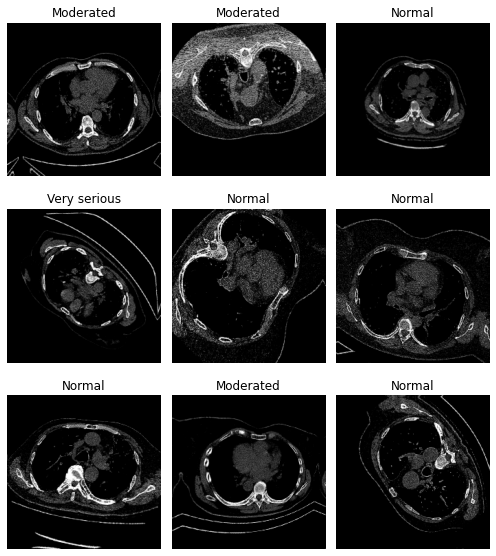

In [8]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [10]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

# Entrenamiento del modelo

In [11]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.434647,1.708488,0.401099,00:49
1,2.032867,1.144204,0.545788,00:48
2,1.795575,1.072643,0.571429,00:49
3,1.577421,1.076387,0.560440,00:49
4,1.424552,0.945734,0.582418,00:49
5,1.261981,0.919778,0.595238,00:49
6,1.137914,0.928200,0.591575,00:48
7,1.034374,0.792327,0.600733,00:50
8,0.976062,0.789967,0.615385,00:49
9,0.927957,0.765395,0.611722,00:48


In [12]:
interp = ClassificationInterpretation.from_learner(learn)

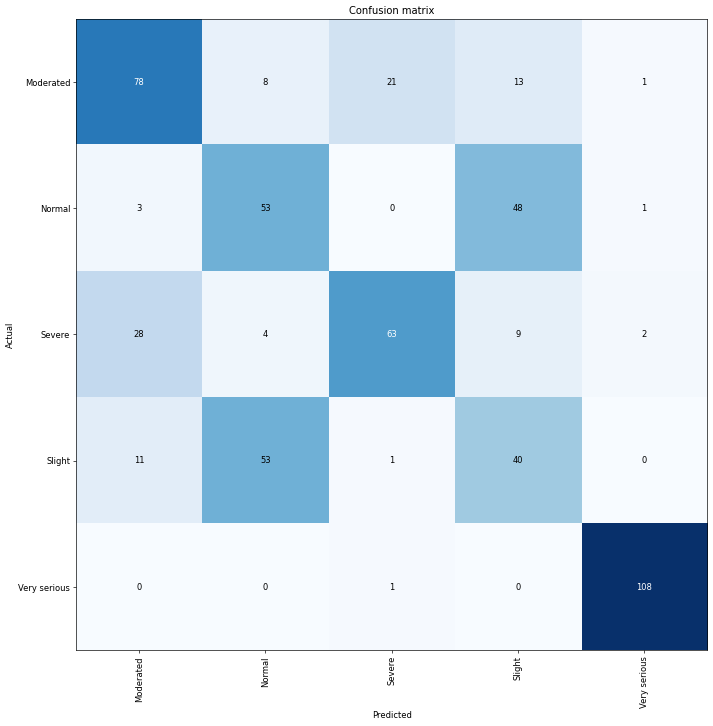

In [13]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

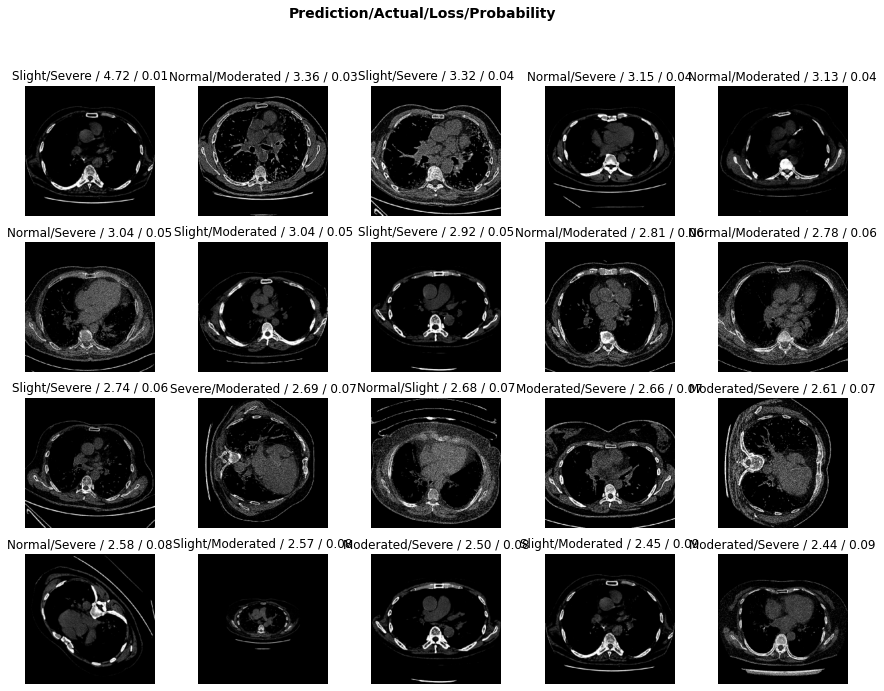

In [14]:
interp.plot_top_losses(20, figsize=(15,11), heatmap=False)

# Implementación de Gradcam

In [39]:
from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

class GradCam():
    @classmethod
    def from_interp(cls,learn,interp,img_idx,ds_type=DatasetType.Valid,include_label=False):
        if ds_type == DatasetType.Valid:
            ds = interp.data.valid_ds
        elif ds_type == DatasetType.Test:
            ds = interp.data.test_ds
            include_label=False
        else:
            return None
        
        x_img = ds.x[img_idx]
        xb,_ = interp.data.one_item(x_img)
        xb_img = Image(interp.data.denorm(xb)[0])
        probs = interp.preds[img_idx].numpy()

        pred_idx = interp.pred_class[img_idx].item() # obtener el idx de clase de la etiqueta de predicción de la img
        hmap_pred,xb_grad_pred = get_grad_heatmap(learn,xb,pred_idx,size=xb_img.shape[-1])
        prob_pred = probs[pred_idx]
        
        actual_args=None
        if include_label:
            actual_idx = ds.y.items[img_idx] # obtener la clase idx de la etiqueta real img
            if actual_idx!=pred_idx:
                hmap_actual,xb_grad_actual = get_grad_heatmap(learn,xb,actual_idx,size=xb_img.shape[-1])
                prob_actual = probs[actual_idx]
                actual_args=[interp.data.classes[actual_idx],prob_actual,hmap_actual,xb_grad_actual]
        
        return cls(xb_img,interp.data.classes[pred_idx],prob_pred,hmap_pred,xb_grad_pred,actual_args)
    
    @classmethod
    def from_one_img(cls,learn,x_img,label1=None,label2=None):
        '''
        learn: fastai's Learner
        x_img: fastai.vision.image.Image
        label1: generar un mapa de calor de acuerdo con esta etiqueta. Si no hay ninguna, esta será la etiqueta con mayor probabilidad del modelo
        label2: generar un mapa de calor adicional de acuerdo con esta etiqueta
        '''
        pred_class,pred_idx,probs = learn.predict(x_img)
        label1= str(pred_class) if not label1 else label1
        
        xb,_ = learn.data.one_item(x_img)
        xb_img = Image(learn.data.denorm(xb)[0])
        probs = probs.numpy()
        
        label1_idx = learn.data.classes.index(label1)
        hmap1,xb_grad1 = get_grad_heatmap(learn,xb,label1_idx,size=xb_img.shape[-1])
        prob1 = probs[label1_idx]
        
        label2_args = None
        if label2:
            label2_idx = learn.data.classes.index(label2)
            hmap2,xb_grad2 = get_grad_heatmap(learn,xb,label2_idx,size=xb_img.shape[-1])
            prob2 = probs[label2_idx]
            label2_args = [label2,prob2,hmap2,xb_grad2]
            
        return cls(xb_img,label1,prob1,hmap1,xb_grad1,label2_args)
    
    def __init__(self,xb_img,label1,prob1,hmap1,xb_grad1,label2_args=None):
        self.xb_img=xb_img
        self.label1,self.prob1,self.hmap1,self.xb_grad1 = label1,prob1,hmap1,xb_grad1
        if label2_args:
            self.label2,self.prob2,self.hmap2,self.xb_grad2 = label2_args
            
    def plot(self,plot_hm=True,plot_gbp=True):
        if not plot_hm and not plot_gbp:
            plot_hm=True
        cols = 5 if hasattr(self, 'label2') else 3
        if not plot_gbp or not plot_hm:
            cols-= 2 if hasattr(self, 'label2') else 1

        fig,row_axes = plt.subplots(1,cols,figsize=(cols*5,5))  
        col=0
        size=self.xb_img.shape[-1]
        self.xb_img.show(row_axes[col]);col+=1
        
        label1_title = f'1.{self.label1} {self.prob1:.3f}'
        if plot_hm:
            show_heatmap(self.hmap1,self.xb_img,size,row_axes[col])
            row_axes[col].set_title(label1_title);col+=1
        if plot_gbp:
            row_axes[col].imshow(self.xb_grad1)
            row_axes[col].set_axis_off()
            row_axes[col].set_title(label1_title);col+=1
        
        if hasattr(self, 'label2'):
            label2_title = f'2.{self.label2} {self.prob2:.3f}'
            if plot_hm:
                show_heatmap(self.hmap2,self.xb_img,size,row_axes[col])
                row_axes[col].set_title(label2_title);col+=1
            if plot_gbp:
                row_axes[col].imshow(self.xb_grad2)
                row_axes[col].set_axis_off()
                row_axes[col].set_title(label2_title)
        # plt.tight_layout()
        fig.subplots_adjust(wspace=0, hspace=0)
        fig.savefig('/content/drive/My Drive/Colab Notebooks/Gradcam/gradcam.png') #Almacena la imagen

def minmax_norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))
def scaleup(x,size):
    scale_mult=size/x.shape[0]
    upsampled = scipy.ndimage.zoom(x, scale_mult)
    return upsampled

# hook for Gradcam
def hooked_backward(m,xb,target_layer,clas):
    with hook_output(target_layer) as hook_a: 
        with hook_output(target_layer, grad=True) as hook_g: 
            preds = m(xb)
            preds[0,int(clas)].backward()
    return hook_a,hook_g

def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)
        

def hooked_ReLU(m,xb,clas):
    relu_modules = [module[1] for module in m.named_modules() if str(module[1]) == "ReLU(inplace)"]
    with callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False) as _:
        preds = m(xb)
        preds[0,int(clas)].backward()
        
def guided_backprop(learn,xb,y):
    xb = xb.cuda()
    m = learn.model.eval();
    xb.requires_grad_();
    if not xb.grad is None:
        xb.grad.zero_(); 
    hooked_ReLU(m,xb,y);
    return xb.grad[0].cpu().numpy()

def show_heatmap(hm,xb_im,size,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.8, extent=(0,size,size,0),
              interpolation='bilinear',cmap='magma');

def get_grad_heatmap(learn,xb,y,size):
    '''
    Función principal para obtener hmap para el heatmap y xb_grad para el backprop guiado
    '''
    xb = xb.cuda()
    m = learn.model.eval();
    target_layer = m[0][-1][-1] # la última capa del grupo 0
    hook_a,hook_g = hooked_backward(m,xb,target_layer,y)
    
    target_act= hook_a.stored[0].cpu().numpy()
    target_grad = hook_g.stored[0][0].cpu().numpy()
    
    mean_grad = target_grad.mean(1).mean(1)
    hmap = (target_act*mean_grad[...,None,None]).sum(0)
    hmap = np.where(hmap >= 0, hmap, 0)
    
    xb_grad = guided_backprop(learn,xb,y)
    xb_grad = minmax_norm(xb_grad)
    hmap_scaleup = minmax_norm(scaleup(hmap,size)) # (224,224)
    
    # multiplicar xb_grad y hmap_scaleup y cambiar el axis
    xb_grad = np.einsum('ijk, jk->jki',xb_grad, hmap_scaleup) #(224,224,3)
    
    return hmap,xb_grad

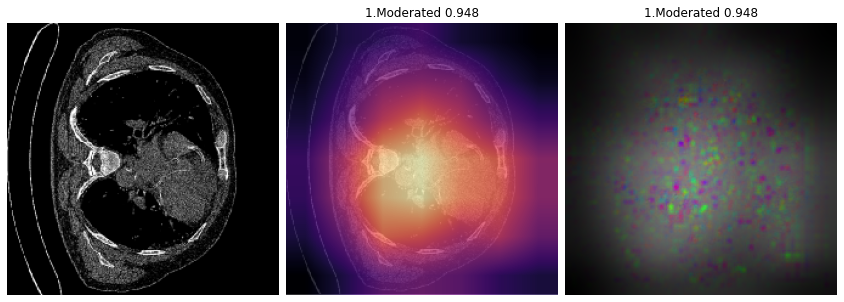

In [44]:
Path = '/content/drive/My Drive/Colab Notebooks/Test/Moderated/270Moderated(115).png'

img = open_image(Path);
gcam = GradCam.from_one_img(learn,img)
gcam.plot()

# Implementación de Bounding Box (Intento)

In [59]:
from google.colab.patches import cv2_imshow

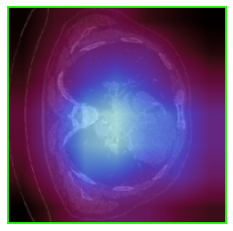

In [65]:
import cv2

im = cv2.imread('/content/drive/My Drive/Colab Notebooks/Gradcam/1.PNG')
gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
idx =0 
for cnt in contours:
    idx += 1
    x,y,w,h = cv2.boundingRect(cnt)
    roi=im[y:y+h,x:x+w]
    cv2.imwrite(str(idx) + '.PNG', roi)
plt.imshow(image)
plt.axis('off')
plt.show()